In [1]:
"""This File Cannot Import Other Files"""

import os
import sys


def set_cuda_visible_devices(gpu_id: int):
    if is_module_imported("torch") or is_module_imported("tensorflow"):
        raise ValueError

    # https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_id}"
    print(f"Set GPU ID to {gpu_id}")


def is_module_imported(module_name: str) -> bool:
    # https://stackoverflow.com/questions/30483246/how-to-check-if-a-python-module-has-been-imported
    return module_name in sys.modules


In [2]:
set_cuda_visible_devices(1)

Set GPU ID to 1


In [3]:
import torch
import numpy as np
import transformers
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict
from transformers import default_data_collator
from typing import Union, Dict, Any, List, Tuple, Optional

from influence_utils import parallel
from influence_utils import faiss_utils
from influence_utils import nn_influence_utils
from experiments import constants
from experiments import misc_utils
from experiments import remote_utils
from experiments import influence_helpers
from experiments.hans_utils import HansHelper
from transformers import TrainingArguments
from experiments.data_utils import (
    glue_output_modes,
    glue_compute_metrics,
    CustomGlueDataset)

DEFAULT_KNN_K = 1000
DEFAULT_NUM_REPLICAS = 3
EXPERIMENT_TYPES = ["most-helpful", "most-harmful", "random"]
DEFAULT_EVAL_HEURISTICS = ["lexical_overlap", "subsequence", "constituent"]
VERSION_2_NUM_DATAPOINTS_CHOICES = [1]
VERSION_2_LEARNING_RATE_CHOICES = [1e-4]


def main(
        train_task_name: str,
        train_heuristic: str,
        eval_heuristics: Optional[List[str]] = None,
        num_replicas: Optional[int] = None,
        use_parallel: bool = True,
        version: Optional[str] = None,
) -> Dict[str, List[Dict[str, Any]]]:

    if train_task_name not in ["mnli-2", "hans"]:
        raise ValueError

    if eval_heuristics is None:
        eval_heuristics = DEFAULT_EVAL_HEURISTICS

    if num_replicas is None:
        num_replicas = DEFAULT_NUM_REPLICAS

    if version is None:
        version = "new"

    if version not in ["old", "new"]:
        raise ValueError

    task_tokenizer, task_model = misc_utils.create_tokenizer_and_model(
        constants.MNLI2_MODEL_PATH)

    (mnli_train_dataset,
     mnli_eval_dataset) = misc_utils.create_datasets(
        task_name="mnli-2",
        tokenizer=task_tokenizer)

    (hans_train_dataset,
     hans_eval_dataset) = misc_utils.create_datasets(
        task_name="hans",
        tokenizer=task_tokenizer)

    if train_task_name == "mnli-2":
        train_dataset = mnli_train_dataset

    if train_task_name == "hans":
        train_dataset = hans_train_dataset

    (s_test_damp,
     s_test_scale,
     s_test_num_samples) = influence_helpers.select_s_test_config(
        trained_on_task_name="mnli-2",
        train_task_name=train_task_name,
        eval_task_name="hans",
    )

    hans_helper = HansHelper(
        hans_train_dataset=hans_train_dataset,
        hans_eval_dataset=hans_eval_dataset)

    # We will be running model trained on MNLI-2
    # but calculate influences on HANS dataset
    faiss_index = influence_helpers.load_faiss_index(
        trained_on_task_name="mnli-2",
        train_task_name=train_task_name
    )

    output_mode = glue_output_modes["mnli-2"]

    def build_compute_metrics_fn(task_name: str):
        def compute_metrics_fn(p):
            if output_mode == "classification":
                preds = np.argmax(p.predictions, axis=1)
            elif output_mode == "regression":
                preds = np.squeeze(p.predictions)
            return glue_compute_metrics(task_name, preds, p.label_ids)

        return compute_metrics_fn

    # Most of these arguments are placeholders
    # and are not really used at all, so ignore
    # the exact values of these.
    trainer = transformers.Trainer(
        model=task_model,
        args=TrainingArguments(
            output_dir="./tmp-output",
            per_device_train_batch_size=128,
            per_device_eval_batch_size=128,
            learning_rate=5e-5,
            logging_steps=100),
    )

    print(task_model.training, task_model.training is False)
    return hans_helper, trainer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
hans_helper, trainer = main(
    train_task_name="hans",
    train_heuristic=DEFAULT_EVAL_HEURISTICS[1],
    use_parallel=False)

Params Trainable: 14767874
	bert.encoder.layer.10.attention.self.query.weight
	bert.encoder.layer.10.attention.self.query.bias
	bert.encoder.layer.10.attention.self.key.weight
	bert.encoder.layer.10.attention.self.key.bias
	bert.encoder.layer.10.attention.self.value.weight
	bert.encoder.layer.10.attention.self.value.bias
	bert.encoder.layer.10.attention.output.dense.weight
	bert.encoder.layer.10.attention.output.dense.bias
	bert.encoder.layer.10.attention.output.LayerNorm.weight
	bert.encoder.layer.10.attention.output.LayerNorm.bias
	bert.encoder.layer.10.intermediate.dense.weight
	bert.encoder.layer.10.intermediate.dense.bias
	bert.encoder.layer.10.output.dense.weight
	bert.encoder.layer.10.output.dense.bias
	bert.encoder.layer.10.output.LayerNorm.weight
	bert.encoder.layer.10.output.LayerNorm.bias
	bert.encoder.layer.11.attention.self.query.weight
	bert.encoder.layer.11.attention.self.query.bias
	bert.encoder.layer.11.attention.self.key.weight
	bert.encoder.layer.11.attention.self.ke

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


False True


In [5]:
from collections import defaultdict
def evaluate_heuristic(
        hans_helper: HansHelper,
        heuristic: str,
        trainer: transformers.Trainer,
        model: torch.nn.Module,
) -> Tuple[float, float]:

    _, batch_dataloader = hans_helper.get_dataset_and_dataloader_of_heuristic(
        mode="eval",
        heuristic=heuristic,
        batch_size=1000,
        random=False)

    loss = 0.
    num_corrects = 0.
    num_examples = 0
    output_collection = defaultdict(list)
    for index, inputs in enumerate(batch_dataloader):
        batch_size = inputs["labels"].shape[0]
        batch_preds, batch_label_ids, batch_mean_loss = misc_utils.predict(
            trainer=trainer,
            model=model,
            inputs=inputs)

        num_examples += batch_size
        loss += batch_mean_loss * batch_size
        num_corrects += (batch_preds.argmax(axis=-1) == batch_label_ids).sum()
        
        output_collection["batch_size"].append(batch_size)
        output_collection["batch_preds"].append(batch_preds)
        output_collection["batch_label_ids"].append(batch_label_ids)
    return output_collection, loss / num_examples, num_corrects / num_examples


In [6]:
from tqdm import trange

losses = []
accuracies = []
output_collections = []
for i in trange(10):
    new_model = torch.load(f"./figures/hans-model-debug-2.{i}.pt")
    print(new_model.training)

    output_collection, new_model_loss, new_model_accuracy = evaluate_heuristic(
        hans_helper=hans_helper,
        heuristic="lexical_overlap",
        trainer=trainer,
        model=new_model)
    
    losses.append(new_model_loss)
    accuracies.append(new_model_accuracy)
    output_collections.append(output_collection)

  0%|          | 0/10 [00:00<?, ?it/s]

False


 10%|█         | 1/10 [00:48<07:12, 48.04s/it]

False


 20%|██        | 2/10 [01:35<06:22, 47.81s/it]

False


 30%|███       | 3/10 [02:22<05:33, 47.66s/it]

False


 40%|████      | 4/10 [03:09<04:45, 47.55s/it]

False


 50%|█████     | 5/10 [03:57<03:57, 47.48s/it]

False


 60%|██████    | 6/10 [04:44<03:09, 47.44s/it]

False


 70%|███████   | 7/10 [05:32<02:22, 47.43s/it]

False


 80%|████████  | 8/10 [06:19<01:34, 47.41s/it]

False


 90%|█████████ | 9/10 [07:06<00:47, 47.40s/it]

False


100%|██████████| 10/10 [07:54<00:00, 47.42s/it]


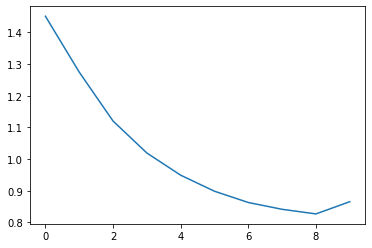

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses)

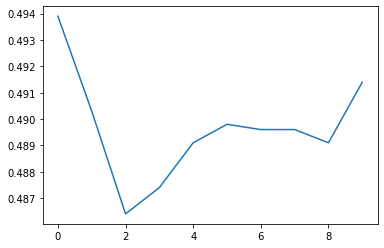

In [10]:
plt.plot(accuracies)

In [14]:
import numpy as np
from scipy.special import softmax

In [25]:
predictions = []
label_ids = []
for j in range(len(output_collections)):
    output_collections[j]["batch_size"]
    predictions.append(
        np.concatenate(output_collections[j]["batch_preds"], axis=0))
    label_ids.append(
        np.concatenate(output_collections[j]["batch_label_ids"], axis=0))

In [205]:
k = -1
# np.log(softmax(predictions[k], axis=-1)[np.arange(len(label_ids[k])), label_ids[k]]).mean()

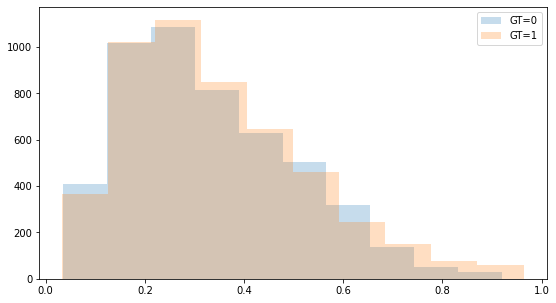

In [206]:
plt.figure(figsize=(20,5))
plt.subplot(121)
probs_0 = softmax(predictions[k], axis=-1)[label_ids[k] == 0]
probs_1 = softmax(predictions[k], axis=-1)[label_ids[k] == 1]
# plt.hist(probs[:, 0], label=0)
plt.hist(probs_0[:, 0], label="GT=0", alpha=0.25)
plt.hist(probs_1[:, 0], label="GT=1", alpha=0.25)
plt.legend()

In [207]:
np.log(probs_0)[:, 0].mean(), np.log(probs_1)[:, 1].mean(), (np.log(probs_0)[:, 0].mean() + np.log(probs_1)[:, 1].mean()) /2 , losses[k]

(-1.246266, -0.48458168, -0.865423858165741, 0.8654238730669022)